# Regression example using PT-MELT
This is a basic regression example using the models in PT-MELT.

Requires the following additional packages:
* ipykernel
* scikit-learn
* matplotlib
* torchinfo

In [1]:
import sklearn.datasets as sdt
import matplotlib.pyplot as plt

# Create surogate data
n_samples = 1000
n_features = 10
n_info = 5
n_targets = 3
noise = 10

x, y = sdt.make_regression(
    n_samples=n_samples, 
    n_features=n_features, 
    n_informative=n_info, 
    n_targets=n_targets, 
    noise=noise, 
    random_state=42,
)
print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

Shape of x: (1000, 10), Shape of y: (1000, 3)


In [2]:
# Use sklearn scaling libraries to normalize the data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

x_normalizer = StandardScaler()
y_normalizer = StandardScaler()

x_normalizer.fit(x)
y_normalizer.fit(y)

x_norm = x_normalizer.transform(x)
y_norm = y_normalizer.transform(y)

# Create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
# Create the validation dataset from the test dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Precompute the un-normalized data for later use
y_train_real = y_normalizer.inverse_transform(y_train)
y_test_real = y_normalizer.inverse_transform(y_test)
y_val_real = y_normalizer.inverse_transform(y_val)

# Hyperparameters
Set consistent hyperparameters for all models for comparisons sake.

In [3]:
# General hyperparameters
n_epochs = 300
batch_size = 32
loss = "mse"
learn_rate = 1e-3
l1_reg = 0
l2_reg = 0
act_fun = "relu"
dropout = 0.0
input_dropout = 0.0
batch_norm = False
batch_norm_type = "ema"
output_activation = "linear"

width = 8
depth = 2

# ResNet specific hyperparameters
layers_per_block = 4

# Make a history dict for storing metrics
history = {"loss": [], "val_loss": []}

## Artificial Neural Network (ANN)
Create and train an ANN using PT-MELT.

In [4]:
from ptmelt.models import ArtificialNeuralNetwork
from torchinfo import summary
import torch
from torch import nn, optim


# Create the model
ann_model = ArtificialNeuralNetwork(
    num_features=n_features,
    num_outputs=n_targets,
    width=width,
    depth=depth,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    batch_norm_type=batch_norm_type,
    output_activation=output_activation,
)


# Build the model and print the summary
ann_model.build()
print(summary(ann_model, input_size=(1, n_features)))

# Define the loss function and optimizer for training
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(ann_model.parameters(), lr=learn_rate)
# optimizer = optim.Adam(ann_model.parameters(), lr=learn_rate, weight_decay=l2_reg)


Layer (type:depth-idx)                   Output Shape              Param #
ArtificialNeuralNetwork                  [1, 3]                    --
├─ModuleDict: 1-1                        --                        --
│    └─Linear: 2-1                       [1, 8]                    88
│    └─ReLU: 2-2                         [1, 8]                    --
│    └─Linear: 2-3                       [1, 8]                    72
│    └─ReLU: 2-4                         [1, 8]                    --
│    └─Linear: 2-5                       [1, 8]                    72
│    └─ReLU: 2-6                         [1, 8]                    --
│    └─Linear: 2-7                       [1, 3]                    27
│    └─Identity: 2-8                     [1, 3]                    --
Total params: 259
Trainable params: 259
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


In [5]:
from torch.utils.data import DataLoader, TensorDataset

# Create the data holder for training/validation (the test set should be held separate from any model training)
dataset = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
dataset_val = TensorDataset(torch.from_numpy(x_val).float(), torch.from_numpy(y_val).float())

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

In [6]:
# Fit the model using the built-in training loop
ann_model.fit(
    train_dl = dataloader,
    val_dl = dataloader_val,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=n_epochs,
)

history = ann_model.history

  0%|          | 0/300 [00:00<?, ?it/s]

  9%|▊         | 26/300 [00:00<00:02, 125.79it/s]

Epoch 10, Loss: 0.2227, Val Loss: 0.2500
Epoch 20, Loss: 0.1039, Val Loss: 0.1184
Epoch 30, Loss: 0.0660, Val Loss: 0.0716


 18%|█▊        | 54/300 [00:00<00:01, 131.23it/s]

Epoch 40, Loss: 0.0476, Val Loss: 0.0529
Epoch 50, Loss: 0.0374, Val Loss: 0.0425
Epoch 60, Loss: 0.0319, Val Loss: 0.0302


 32%|███▏      | 96/300 [00:00<00:01, 133.93it/s]

Epoch 70, Loss: 0.0277, Val Loss: 0.0261
Epoch 80, Loss: 0.0244, Val Loss: 0.0230
Epoch 90, Loss: 0.0220, Val Loss: 0.0214


 41%|████▏     | 124/300 [00:00<00:01, 136.13it/s]

Epoch 100, Loss: 0.0201, Val Loss: 0.0197
Epoch 110, Loss: 0.0186, Val Loss: 0.0165
Epoch 120, Loss: 0.0175, Val Loss: 0.0176


 51%|█████     | 152/300 [00:01<00:01, 136.97it/s]

Epoch 130, Loss: 0.0166, Val Loss: 0.0182
Epoch 140, Loss: 0.0161, Val Loss: 0.0187
Epoch 150, Loss: 0.0157, Val Loss: 0.0158


 60%|██████    | 180/300 [00:01<00:00, 137.15it/s]

Epoch 160, Loss: 0.0154, Val Loss: 0.0167
Epoch 170, Loss: 0.0152, Val Loss: 0.0158
Epoch 180, Loss: 0.0150, Val Loss: 0.0159


 70%|██████▉   | 209/300 [00:01<00:00, 138.38it/s]

Epoch 190, Loss: 0.0151, Val Loss: 0.0157
Epoch 200, Loss: 0.0147, Val Loss: 0.0168
Epoch 210, Loss: 0.0147, Val Loss: 0.0160


 80%|███████▉  | 239/300 [00:01<00:00, 139.93it/s]

Epoch 220, Loss: 0.0149, Val Loss: 0.0151
Epoch 230, Loss: 0.0144, Val Loss: 0.0186
Epoch 240, Loss: 0.0144, Val Loss: 0.0176


 90%|████████▉ | 269/300 [00:01<00:00, 139.84it/s]

Epoch 250, Loss: 0.0144, Val Loss: 0.0193
Epoch 260, Loss: 0.0144, Val Loss: 0.0151
Epoch 270, Loss: 0.0141, Val Loss: 0.0154


100%|██████████| 300/300 [00:02<00:00, 136.77it/s]

Epoch 280, Loss: 0.0143, Val Loss: 0.0149
Epoch 290, Loss: 0.0140, Val Loss: 0.0184
Epoch 300, Loss: 0.0140, Val Loss: 0.0186


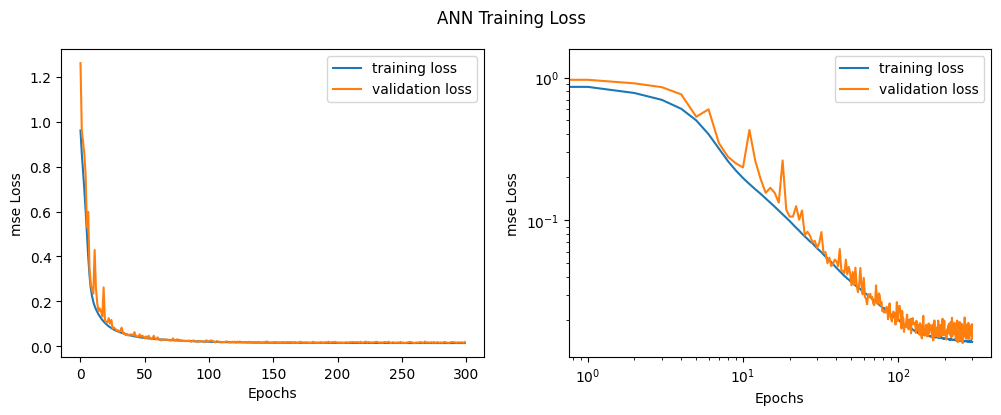

In [7]:
# Plot the loss function over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history["loss"], label="training loss")
ax1.plot(history["val_loss"], label="validation loss")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel(f"{loss} Loss")

ax2.loglog(history["loss"], label="training loss")
ax2.loglog(history["val_loss"], label="validation loss")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel(f"{loss} Loss")

fig.suptitle("ANN Training Loss")
plt.show()

In [8]:
# Evaluate the model performance on train and validation data
ann_model.eval()
print(f"Training: {ann_model.training}")
# convert numpy array to tensor
pred_norm = ann_model(torch.from_numpy(x_norm).float())
pred_norm_train = ann_model(torch.from_numpy(x_train).float())
pred_norm_val = ann_model(torch.from_numpy(x_val).float())
pred_norm_test = ann_model(torch.from_numpy(x_test).float())

# Unscale the results and plot
pred_full = y_normalizer.inverse_transform(pred_norm.detach().numpy())
pred_train = y_normalizer.inverse_transform(pred_norm_train.detach().numpy())
pred_val = y_normalizer.inverse_transform(pred_norm_val.detach().numpy())
pred_test = y_normalizer.inverse_transform(pred_norm_test.detach().numpy())

Training: False


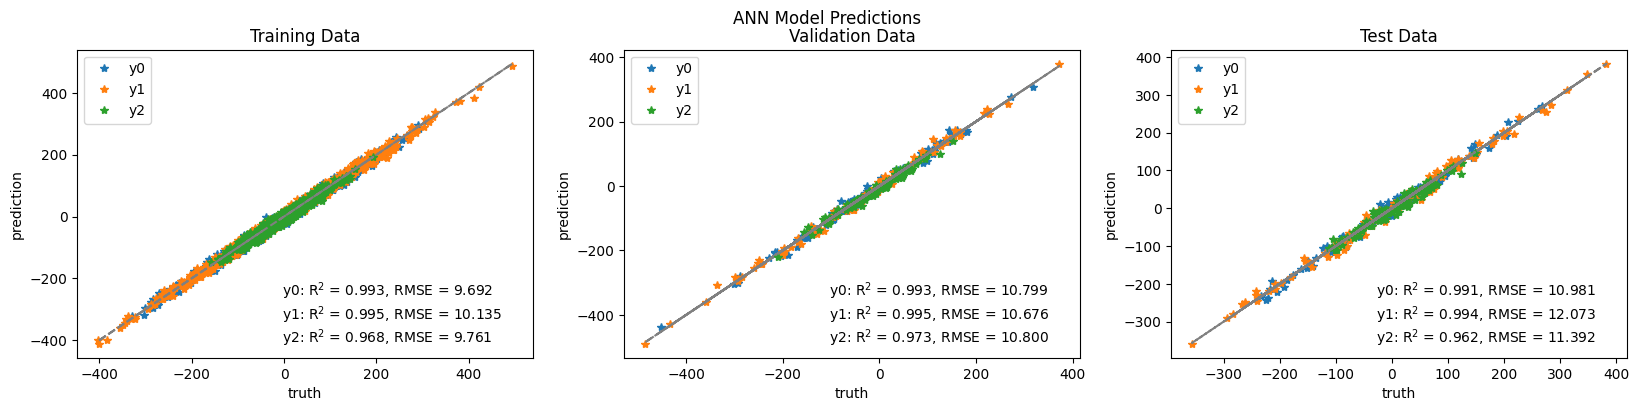

In [9]:
# Compute some statistics on the fit
import numpy as np

def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/(truth+1e-6))**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
# Train plot
for i in range(n_targets):
    ax1.plot(y_train_real[:, i], pred_train[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    # ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
    ax1.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    # Validation plot
    ax2.plot(y_val_real[:, i], pred_val[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    # Test plot
    ax3.plot(y_test_real[:, i], pred_test[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")

fig.suptitle('ANN Model Predictions')
plt.show()

## Residual Neural Network (ResNet)
Create and train a ResNet using PT-MELT.

In [16]:
from ptmelt.models import ResidualNeuralNetwork

# Create the model
resnet_model = ResidualNeuralNetwork(
    num_features=n_features,
    num_outputs=n_targets,
    width=width,
    depth=depth,
    layers_per_block=layers_per_block,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    batch_norm_type=batch_norm_type,
    pre_activation=True,
    post_add_activation=False,
    output_activation=output_activation,
)

# Build the model and print the summary
resnet_model.build()
print(summary(resnet_model, input_size=(1, n_features)))

# Define the loss function and optimizer for training
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(resnet_model.parameters(), lr=learn_rate)


Layer (type:depth-idx)                   Output Shape              Param #
ResidualNeuralNetwork                    [1, 3]                    --
├─ModuleDict: 1-1                        --                        --
│    └─Linear: 2-1                       [1, 8]                    88
│    └─ReLU: 2-2                         [1, 8]                    --
│    └─Linear: 2-3                       [1, 8]                    72
│    └─ReLU: 2-4                         [1, 8]                    --
│    └─Linear: 2-5                       [1, 8]                    72
│    └─ReLU: 2-6                         [1, 8]                    --
│    └─Linear: 2-7                       [1, 3]                    27
│    └─Identity: 2-8                     [1, 3]                    --
Total params: 259
Trainable params: 259
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


/Users/nwimer/miniconda3/envs/pt-melt/lib/python3.12/site-packages/ptmelt/models.py:330: UserWarning: Warning: depth 2 is not divisible by layers_per_block (4), so the last block will have 2 layers.
  warnings.warn(


In [17]:
# Fit the model using the built-in training loop
resnet_model.fit(
    train_dl = dataloader,
    val_dl = dataloader_val,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=n_epochs,
)

history = resnet_model.history

  9%|▊         | 26/300 [00:00<00:02, 127.37it/s]

Epoch 10, Loss: 0.8534, Val Loss: 1.2083
Epoch 20, Loss: 0.1802, Val Loss: 0.1650
Epoch 30, Loss: 0.0953, Val Loss: 0.1104


 18%|█▊        | 54/300 [00:00<00:01, 134.20it/s]

Epoch 40, Loss: 0.0672, Val Loss: 0.0950
Epoch 50, Loss: 0.0506, Val Loss: 0.0577
Epoch 60, Loss: 0.0399, Val Loss: 0.0414


 32%|███▏      | 96/300 [00:00<00:01, 131.78it/s]

Epoch 70, Loss: 0.0322, Val Loss: 0.0342
Epoch 80, Loss: 0.0271, Val Loss: 0.0374
Epoch 90, Loss: 0.0235, Val Loss: 0.0280


 41%|████▏     | 124/300 [00:00<00:01, 131.50it/s]

Epoch 100, Loss: 0.0213, Val Loss: 0.0227
Epoch 110, Loss: 0.0191, Val Loss: 0.0241
Epoch 120, Loss: 0.0176, Val Loss: 0.0201


 51%|█████     | 152/300 [00:01<00:01, 133.51it/s]

Epoch 130, Loss: 0.0169, Val Loss: 0.0187
Epoch 140, Loss: 0.0162, Val Loss: 0.0186
Epoch 150, Loss: 0.0158, Val Loss: 0.0180


 60%|██████    | 180/300 [00:01<00:00, 132.87it/s]

Epoch 160, Loss: 0.0154, Val Loss: 0.0203
Epoch 170, Loss: 0.0154, Val Loss: 0.0191
Epoch 180, Loss: 0.0151, Val Loss: 0.0177


 69%|██████▉   | 208/300 [00:01<00:00, 133.37it/s]

Epoch 190, Loss: 0.0148, Val Loss: 0.0183
Epoch 200, Loss: 0.0149, Val Loss: 0.0149
Epoch 210, Loss: 0.0146, Val Loss: 0.0155


 79%|███████▊  | 236/300 [00:01<00:00, 131.49it/s]

Epoch 220, Loss: 0.0147, Val Loss: 0.0201
Epoch 230, Loss: 0.0147, Val Loss: 0.0159
Epoch 240, Loss: 0.0146, Val Loss: 0.0154


 88%|████████▊ | 264/300 [00:01<00:00, 132.89it/s]

Epoch 250, Loss: 0.0144, Val Loss: 0.0152
Epoch 260, Loss: 0.0144, Val Loss: 0.0158
Epoch 270, Loss: 0.0142, Val Loss: 0.0164


100%|██████████| 300/300 [00:02<00:00, 132.68it/s]

Epoch 280, Loss: 0.0142, Val Loss: 0.0162
Epoch 290, Loss: 0.0140, Val Loss: 0.0159
Epoch 300, Loss: 0.0142, Val Loss: 0.0173


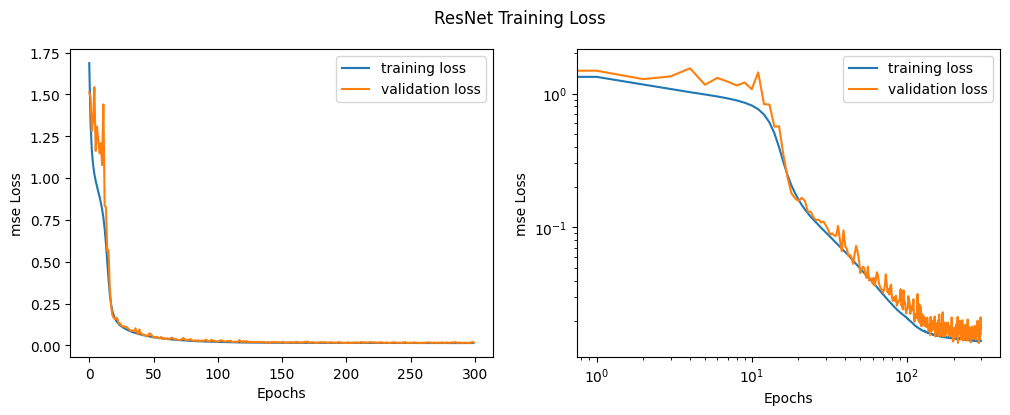

In [18]:
# Plot the loss function over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history["loss"], label="training loss")
ax1.plot(history["val_loss"], label="validation loss")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel(f"{loss} Loss")

ax2.loglog(history["loss"], label="training loss")
ax2.loglog(history["val_loss"], label="validation loss")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel(f"{loss} Loss")

fig.suptitle("ResNet Training Loss")
plt.show()

In [19]:
# Evaluate the model performance on train and validation data
resnet_model.eval()
print(f"Training: {resnet_model.training}")
# convert numpy array to tensor
pred_norm = resnet_model(torch.from_numpy(x_norm).float())
pred_norm_train = resnet_model(torch.from_numpy(x_train).float())
pred_norm_val = resnet_model(torch.from_numpy(x_val).float())
pred_norm_test = resnet_model(torch.from_numpy(x_test).float())

# Unscale the results and plot
pred_full = y_normalizer.inverse_transform(pred_norm.detach().numpy())
pred_train = y_normalizer.inverse_transform(pred_norm_train.detach().numpy())
pred_val = y_normalizer.inverse_transform(pred_norm_val.detach().numpy())
pred_test = y_normalizer.inverse_transform(pred_norm_test.detach().numpy())

Training: False


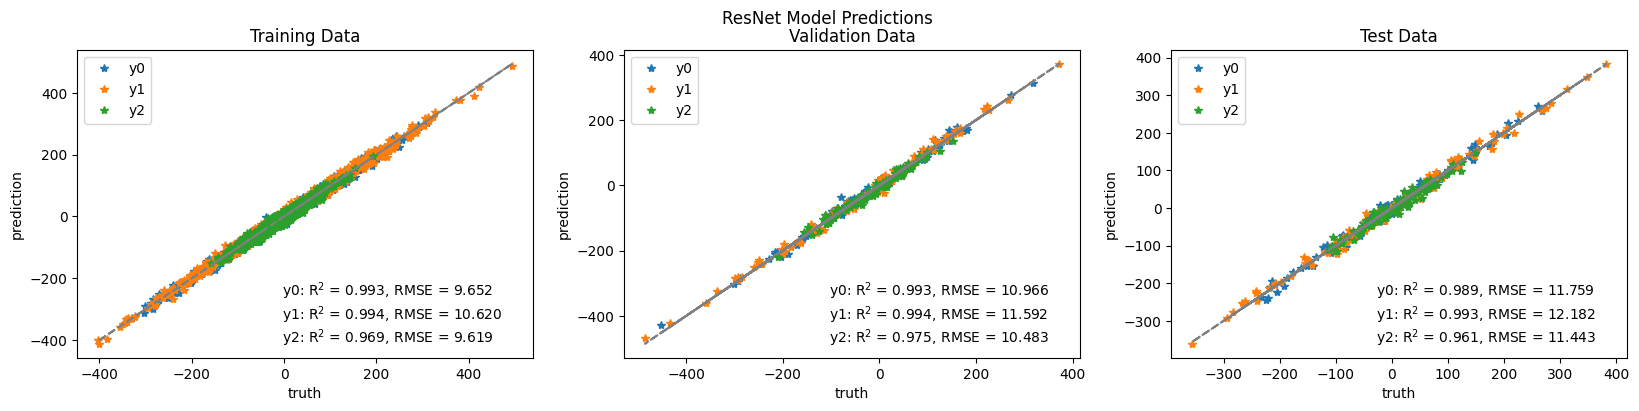

In [20]:
# Compute some statistics on the fit
import numpy as np

def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/(truth+1e-6))**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
# Train plot
for i in range(n_targets):
    ax1.plot(y_train_real[:, i], pred_train[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    # ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
    ax1.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    # Validation plot
    ax2.plot(y_val_real[:, i], pred_val[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    # Test plot
    ax3.plot(y_test_real[:, i], pred_test[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")

fig.suptitle('ResNet Model Predictions')
plt.show()

# Bayesian Neural Network (BNN)

coming soon...